In [18]:
### Auxiliary Functions
import matplotlib.pyplot as plt


def line_chart(ax: plt.Axes, xvalues: list, yvalues: list, title: str, xlabel: str, ylabel: str, percentage=False):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    ax.plot(xvalues, yvalues)

def multiple_line_chart(ax: plt.Axes, xvalues: list, yvalues: dict, title: str, xlabel: str, ylabel: str, percentage=False):
    legend: list = []
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if percentage:
        ax.set_ylim(0.0, 1.0)
    for name, y in yvalues.items():
        ax.plot(xvalues, y)
        legend.append(name)
    ax.legend(legend, loc='best', fancybox = True, shadow = True)   
    
def plot_roc_chart(ax: plt.Axes, models: dict, tstX, tstY, target: str='class'):
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.0])
    ax.set_xlabel('FP rate')
    ax.set_ylabel('TP rate')
    ax.set_title('ROC chart for %s'%target)
    ax.plot([0, 1], [0, 1], color='navy', label='random', linestyle='--')    
    for clf in models:
        scores = models[clf].predict_proba(tstX)[:,1]
        fpr, tpr, _ = metrics.roc_curve(tstY, scores, 'positive')
        roc_auc = metrics.roc_auc_score(tstY, scores)
        ax.plot(fpr, tpr, label='%s (auc=%0.2f)' %(clf, roc_auc))
    ax.legend(loc="lower center")


# Description

##### The goal of this project is to apply data science techniques to discover information in two distinct datasets. The first dataset describes various speech signal processing algorithms applied to the speech recordings of Parkinson's Disease (PD) patients to extract clinically useful information for PD assessment. The second dataset predicts forest cover type from cartographic variables only. It includes four wilderness areas located in the Roosevelt National Forest of northern Colorado. These areas represent forests with minimal human-caused disturbances, so that existing forest cover types are more a result of ecological processes rather than forest management practices.

In [19]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix

data = pd.read_csv('pd_speech_features.csv', sep=',')

data.shape

(756, 755)

In [20]:
cat_vars = data.select_dtypes(include='category')
cat_vars.columns.size

0

In [21]:
num_vars = data.select_dtypes(include='number')
num_vars.columns.size

755

In [22]:
null_vars = {}
for var in data:
    nas = data[var].isna().sum()
    if nas > 0:
        null_vars[var] = nas
print(len(null_vars))

0


In [23]:
data.head(6)

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,...,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
1,0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,...,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
2,0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,...,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
3,1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,...,3.7805,3.5664,5.2558,14.0403,4.2235,4.6857,4.8460,6.2650,4.0603,1
4,1,0,0.32790,0.79782,0.53028,236,235,0.008162,0.002669,0.00535,...,6.1727,5.8416,6.0805,5.7621,7.7817,11.6891,8.2103,5.0559,6.1164,1
5,1,0,0.50780,0.78744,0.65451,226,221,0.007631,0.002696,0.00783,...,4.8025,5.0734,7.0166,5.9966,5.2065,7.4246,3.4153,3.5046,3.2250,1


##### The dataset has 756 records and 755 attributes, all numeric, and does not have any null value.

# Preprocessing

### Reducing Sample Size

##### This dataset describes three measurements for each patient, so we apply the mean of those samples to have one sample per patient.

In [24]:
data = data.groupby('id').mean().reset_index()
data.shape

(252, 755)

In [25]:
data.head(6)

,id,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,...,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
0,0,1.0,0.823387,0.696370,0.567250,235.333333,234.333333,0.008220,0.000073,0.001963,...,1.561733,2.862000,12.293333,9.717500,9.055300,6.259100,4.021533,4.164333,22.961700,1.0
1,1,0.0,0.415637,0.793993,0.592453,213.333333,211.000000,0.008884,0.001849,0.005790,...,4.918567,4.827133,6.117633,8.599667,5.737233,7.933133,5.490533,4.941833,4.467233,1.0
2,2,1.0,0.801973,0.619967,0.520563,319.333333,318.333333,0.006041,0.000104,0.002217,...,41.129400,31.201933,14.584467,5.446800,3.462000,4.772067,9.176633,11.848100,5.552367,1.0
3,3,0.0,0.828707,0.626097,0.537183,493.000000,492.000000,0.003913,0.000042,0.000757,...,1.677633,1.908400,2.842167,3.493867,3.282433,3.085267,3.184433,4.032933,22.773633,1.0
4,4,0.0,0.831287,0.779397,0.726717,362.666667,361.666667,0.005622,0.002023,0.003593,...,4.104600,4.285233,2.953200,2.799933,2.645100,2.811367,7.268333,13.338833,63.766900,1.0
5,5,1.0,0.822520,0.622083,0.357660,284.000000,283.000000,0.006815,0.000046,0.000940,...,25.482500,29.795367,26.472767,43.983700,54.324967,49.879867,43.996667,37.834733,73.894367,1.0


# Classification

##### For the PD dataset, the target variable is 'class' and it is binary.

### Training Strategy

In [26]:
X = data.drop(columns=['class'])
y = data['class'].values

In [27]:
# Hold-Out 
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=12, 
                                                    stratify=y)

In [28]:
# Cross-Validation
skf = StratifiedKFold(n_splits=10)

### KNN

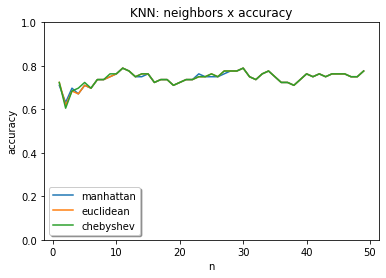

In [29]:
n_neighbors = range(1,50)
dist = ['manhattan', 'euclidean', 'chebyshev']
values = {}
for d in dist:
    accuracy_values = []
    for n in n_neighbors:
        knn = KNeighborsClassifier(n_neighbors=n, metric=d)
        knn.fit(X_train, y_train)
        y_predict = knn.predict(X_test)
        accuracy_values.append(metrics.accuracy_score(y_test, y_predict))
    values[d] = accuracy_values
plt.figure()
multiple_line_chart(plt.gca(), n_neighbors, values, 'KNN: neighbors x accuracy', 'n', 'accuracy', percentage=True)
plt.show()

TypeError: float() argument must be a string or a number, not 'dict_keys'

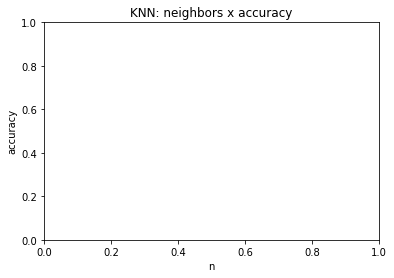

In [30]:
n_neighbors = range(1,50)
values = {}
for n in n_neighbors:
    knn = KNeighborsClassifier(n_neighbors=n, metric='manhattan')
    knn.fit(X_train, y_train)
    y_predict = knn.predict(X_test)
    values[n] = metrics.accuracy_score(y_test, y_predict)
plt.figure()
line_chart(plt.gca(), values.keys(), values.values(), 'KNN: neighbors x accuracy', 'n', 'accuracy', percentage=True)
plt.show()

In [31]:
max(zip(values.values(), values.keys()))

(0.7894736842105263, 30)

##### The distance function doesn't changes significantly the accuracy of the model, so we chose the first one, the manhattan distance. The highest accuracy value corresponds to a model of 30 neighbors. 

In [32]:
knn = KNeighborsClassifier(n_neighbors=30, metric='manhattan')
knn.fit(X_train, y_train)
y_predict = knn.predict(X_test)
    
print("Neighbors: 30")
print("Accuracy: ", round(metrics.accuracy_score(y_test, y_predict),2))
print("Precision: ", round(metrics.precision_score(y_test, y_predict),2))
print("Recall: ", round(metrics.recall_score(y_test, y_predict),2))
print("F1-score: ", round(metrics.f1_score(y_test, y_predict),2))
tn, fp, fn, tp = confusion_matrix(y_test, y_predict).ravel()
specificity = tn / (tn+fp)
print("Specificity: ", round(specificity,2))
sensitivity = tp / (tp + fn)
print("Sensitivity: ", round(sensitivity,2))

Neighbors: 30
Accuracy:  0.79
Precision:  0.8
Recall:  0.96
F1-score:  0.87
Specificity:  0.26
Sensitivity:  0.96


In [ ]:
#knn = KNeighborsClassifier(n_neighbors=30, metric='manhattan')
#score_array = []
#for train_index, test_index in skf.split(X,y):
#    X_train, X_test = X[train_index], X[test_index]
#    y_train, y_test = y[train_index], y[test_index]
#    knn.fit(X_train, y_train)
#    y_predict = knn.predict(X_test)
#    score_array.append(metrics.accuracy_score(y_test, y_predict))

# Unsupervised Learning

### Pattern Mining

In [ ]:
newdf = data.copy()
newdf.shape
newdf.head(5)

In [ ]:
# Equal-width discretization
for col in newdf:
    if col not in ['gender', 'class', 'id']:
        newdf[col] = pd.cut(newdf[col],3,labels=['0','1','2'])
newdf.head(5)

##### Since this is an unsupervised technique we removed the target column, 'class'. The column 'id' is also irrelevant for this analysis.

In [ ]:
newdf = newdf.drop(columns=['class', 'id'])
newdf.head(5)

In [ ]:
dummylist = []
for att in newdf:
    dummylist.append(pd.get_dummies(newdf[[att]]))
dummified_df = pd.concat(dummylist, axis=1)
dummified_df.head(5)

In [ ]:
dummified_df.shape